Importing


In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

Retrieving Data From Yfinance


In [11]:
ticker = "RELIANCE.NS"

data = yf.download(ticker, period="2y", interval="1d")
data = data.rename(columns={"Open": "open","High": "high","Low": "low","Close": "close","Adj Close": "adj_close","Volume": "volume"})


data.head()

/tmp/ipython-input-4095509702.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="2y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2023-12-26,1279.554443,1286.453333,1271.935784,1274.566338,7465664
2023-12-27,1283.922119,1290.399082,1277.097630,1281.514887,9204156
2023-12-28,1293.203369,1296.404650,1283.922089,1285.386228,12302636
2023-12-29,1282.979126,1297.397435,1280.174930,1295.958136,10864584
2024-01-01,1285.609741,1293.848810,1277.122509,1280.795398,4030540


Indicators

In [17]:
# 1. Simple Moving Average (SMA)
def sma(series: pd.Series, window: int) :

    return series.rolling(window=window, min_periods=window).mean()


# 2. Exponential Moving Average (EMA)
def ema(series: pd.Series, window: int) :

    return series.ewm(span=window, adjust=False).mean()
# .ewm() stands for Exponential Weighted Moving Average.
# It calculates a moving average that gives more weight to recent values
# and less weight to older values.


# 3. MACD (12, 26, 9)
def macd(series: pd.Series,fast: int = 12,slow: int = 26,signal: int = 9):

    ema_fast = ema(series, fast)
    ema_slow = ema(series, slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist


# 4. RSI (Relative Strength Index) – period 14
def rsi(series: pd.Series, period: int = 14):
    delta = series.diff()


    gain = delta.copy()
    loss = delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    loss = -loss

    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi_series = 100 - (100 / (1 + rs))
    return rsi_series



# 5. Stochastic Oscillator (14,3)
def stochastic_oscillator(high: pd.Series,low: pd.Series,close: pd.Series,k_period: int = 14,d_period: int = 3):

    lowest_low = low.rolling(window=k_period, min_periods=k_period).min()
    highest_high = high.rolling(window=k_period, min_periods=k_period).max()

    k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    d = k.rolling(window=d_period, min_periods=d_period).mean()
    return k, d


# 6. Bollinger Bands (20, 2)
def bollinger_bands(series: pd.Series,window: int = 20,num_std: float = 2.0):

    mid = sma(series, window)
    rolling_std = series.rolling(window=window, min_periods=window).std()

    upper = mid + num_std * rolling_std
    lower = mid - num_std * rolling_std
    return mid, upper, lower


Doing the Calc's (VERY IMP TABLE)

In [36]:
data.columns = data.columns.get_level_values(0)



close = data["close"]
high = data["high"]
low = data["low"]

# 1. SMA 20
data["SMA_20"] = sma(close, 20)

# 2. EMA 20
data["EMA_20"] = ema(close, 20)

# 3. MACD
data["MACD_line"], data["MACD_signal"], data["MACD_hist"] = macd(close)

# 4. RSI 14
data["RSI_14"] = rsi(close, period=14)

# 5. Stochastic Oscillator (14,3)
data["Stoch_%K"], data["Stoch_%D"] = stochastic_oscillator(high, low, close)

# 6. Bollinger Bands (20,2)
data["BB_mid"], data["BB_upper"], data["BB_lower"] = bollinger_bands(close, window=20, num_std=2.0)

data.tail(100)

Price,close,high,low,open,volume,SMA_20,EMA_20,MACD_line,MACD_signal,MACD_hist,RSI_14,Stoch_%K,Stoch_%D,BB_mid,BB_upper,BB_lower
Date,,,,,,,,,,,,,,,,
2025-08-01,1388.155762,1400.307303,1378.793253,1381.382885,10321171,1448.061560,1429.274146,-21.342298,-13.026780,-8.315518,25.463451,10.061240,12.460894,1448.061560,1553.784774,1342.338346
2025-08-04,1405.885010,1410.466687,1386.163726,1389.550225,6312820,1441.587415,1427.046610,-20.372645,-14.495953,-5.876692,31.478664,26.930197,14.594202,1441.587415,1540.434250,1342.740579
2025-08-05,1386.163696,1405.386969,1382.578042,1405.386969,9315972,1434.321429,1423.152999,-20.953989,-15.787560,-5.166429,28.571421,8.845421,15.278953,1434.321429,1526.483095,1342.159764
2025-08-06,1387.259521,1390.347165,1377.797312,1386.363077,5834312,1428.036536,1419.734572,-21.083250,-16.846698,-4.236552,30.189622,10.331556,15.369058,1428.036536,1514.592426,1341.480646
2025-08-07,1383.872925,1388.155746,1360.565987,1382.179615,9976705,1421.671954,1416.319177,-21.214414,-17.720241,-3.494172,29.766390,21.272738,13.483239,1421.671954,1500.900644,1342.443265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-18,1544.400024,1551.500000,1535.199951,1535.199951,6580829,1547.425006,1539.019165,11.841073,15.670144,-3.829072,38.006234,44.741299,41.863040,1547.425006,1570.966216,1523.883797
2025-12-19,1565.099976,1574.199951,1551.000000,1554.400024,13937275,1548.350006,1541.503051,12.607499,15.057615,-2.450116,49.567474,83.922298,56.911946,1548.350006,1573.173624,1523.526388
2025-12-22,1575.400024,1577.500000,1565.300049,1573.500000,10184852,1550.325006,1544.731335,13.885957,14.823283,-0.937327,63.713470,96.494199,75.052598,1550.325006,1577.180157,1523.469855


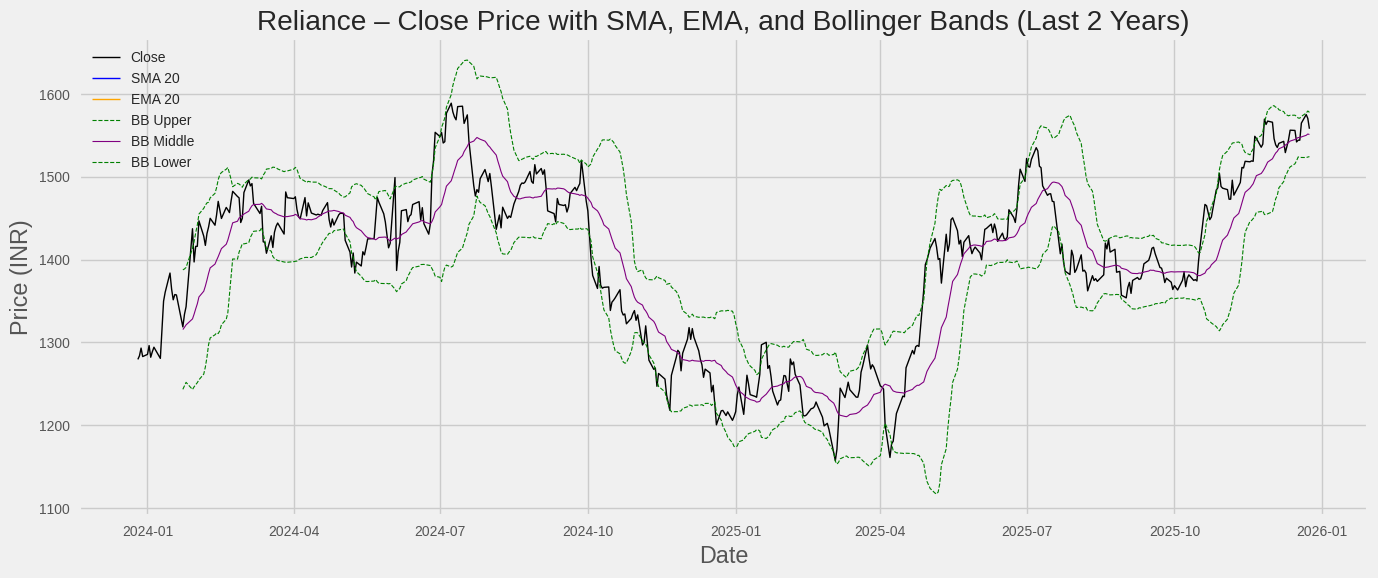

In [29]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(data.index, data["close"], label="Close", color="black", linewidth=1)
ax.plot(data.index, data["SMA_20"], label="SMA 20", color="blue", linewidth=1)
ax.plot(data.index, data["EMA_20"], label="EMA 20", color="orange", linewidth=1)

ax.plot(data.index, data["BB_upper"], label="BB Upper", color="green", linewidth=0.8, linestyle="--")
ax.plot(data.index, data["BB_mid"], label="BB Middle", color="purple", linewidth=0.8)
ax.plot(data.index, data["BB_lower"], label="BB Lower", color="green", linewidth=0.8, linestyle="--")

ax.set_title("Reliance – Close Price with SMA, EMA, and Bollinger Bands (Last 2 Years)")
ax.set_xlabel("Date")
ax.set_ylabel("Price (INR)")
ax.legend()
plt.tight_layout()
plt.show()


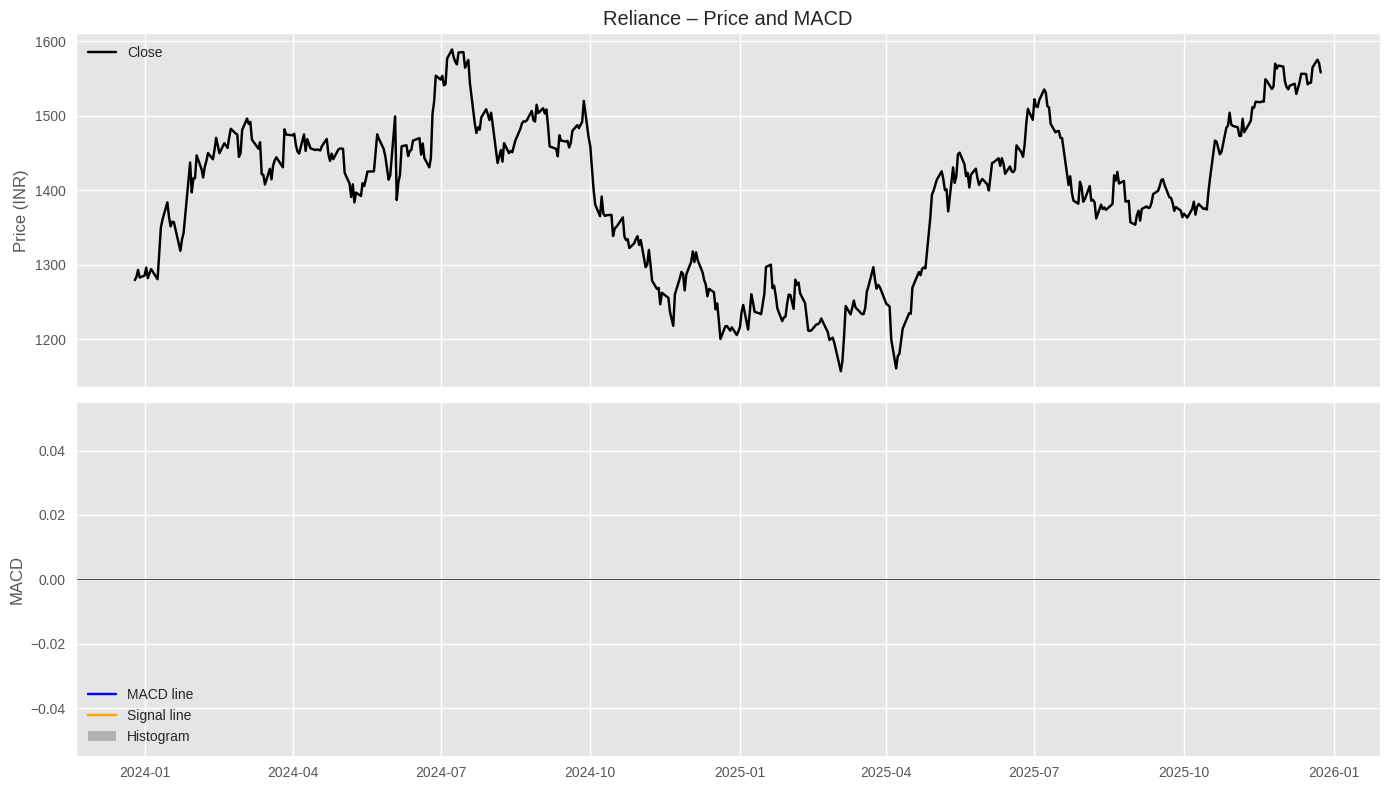

In [25]:
fig, (ax_price, ax_macd) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price
ax_price.plot(data.index, data["close"], label="Close", color="black")
ax_price.set_title("Reliance – Price and MACD")
ax_price.set_ylabel("Price (INR)")
ax_price.legend()

# MACD
ax_macd.plot(data.index, data["MACD_line"], label="MACD line", color="blue")
ax_macd.plot(data.index, data["MACD_signal"], label="Signal line", color="orange")
ax_macd.bar(data.index, data["MACD_hist"], label="Histogram", color="gray", alpha=0.5)

ax_macd.axhline(0, color="black", linewidth=0.5)
ax_macd.set_ylabel("MACD")
ax_macd.legend()

plt.tight_layout()
plt.show()


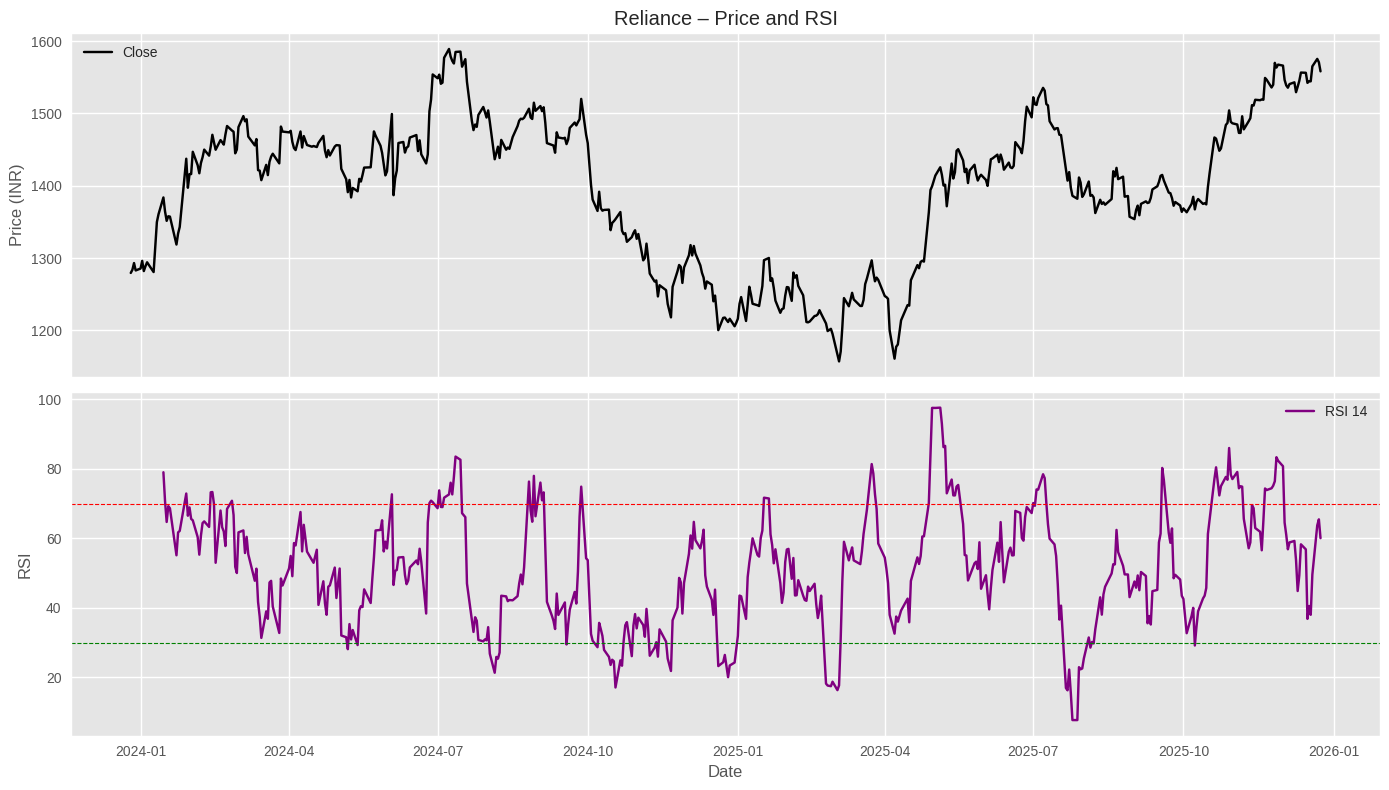

In [26]:
fig, (ax_price, ax_rsi) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax_price.plot(data.index, data["close"], label="Close", color="black")
ax_price.set_title("Reliance – Price and RSI")
ax_price.set_ylabel("Price (INR)")
ax_price.legend()

ax_rsi.plot(data.index, data["RSI_14"], label="RSI 14", color="purple")
ax_rsi.axhline(70, color="red", linestyle="--", linewidth=0.8)
ax_rsi.axhline(30, color="green", linestyle="--", linewidth=0.8)
ax_rsi.set_ylabel("RSI")
ax_rsi.set_xlabel("Date")
ax_rsi.legend()

plt.tight_layout()
plt.show()


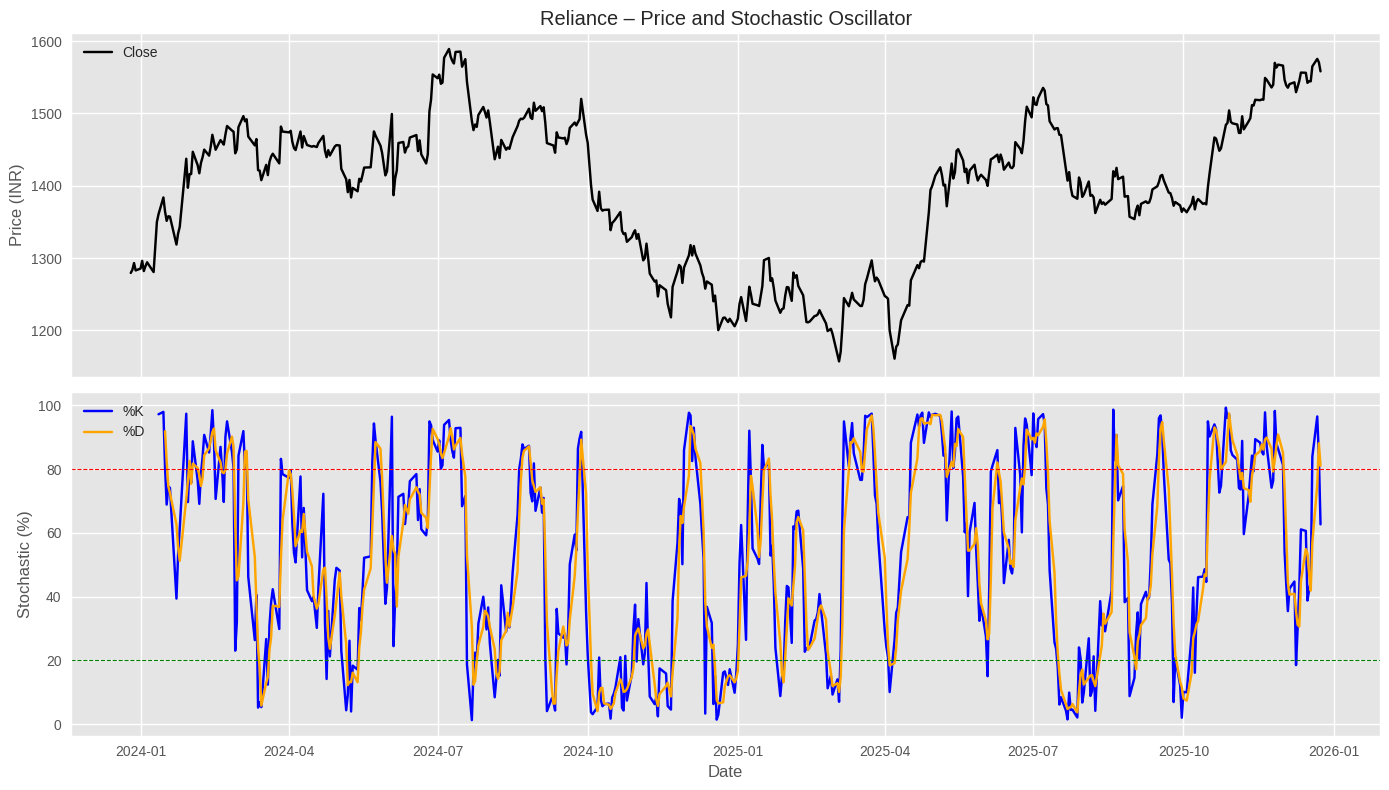

In [27]:
fig, (ax_price, ax_stoch) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax_price.plot(data.index, data["close"], label="Close", color="black")
ax_price.set_title("Reliance – Price and Stochastic Oscillator")
ax_price.set_ylabel("Price (INR)")
ax_price.legend()

ax_stoch.plot(data.index, data["Stoch_%K"], label="%K", color="blue")
ax_stoch.plot(data.index, data["Stoch_%D"], label="%D", color="orange")
ax_stoch.axhline(80, color="red", linestyle="--", linewidth=0.8)
ax_stoch.axhline(20, color="green", linestyle="--", linewidth=0.8)

ax_stoch.set_ylabel("Stochastic (%)")
ax_stoch.set_xlabel("Date")
ax_stoch.legend()

plt.tight_layout()
plt.show()
